# Session happiness prediction

Since around 75% of sessions do not have any student reflection answers (with less than 5% of students answering these questions), it must be useful to gain insight into sessions for schools and teachers to predict whether students were happy or not with these.

In [1]:
# Useful imports
import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from modules import sesh

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression, RidgeCV, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

In [2]:
# Run this cell if working on Colab
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/Classtime'

Mounted at /content/drive


In [3]:
# Load data and attach session ID to each participant
df = pd.read_csv(f'{DATA_DIR}/participants_aggregated.csv.gz')
p_answers = pd.read_csv(f'{DATA_DIR}/classtime_reflection_answers.csv.gz', usecols=['participant_id', 'session_id'])
p_answers = p_answers.drop_duplicates(subset=['participant_id']).set_index('participant_id')
df['session_id'] = df.participant_id.map(p_answers.session_id)
df.drop(columns=['participant_id'], inplace=True)

In [4]:
# Map response to integer for happiness scale 0 - 1
df['response'] = df.response.map({'happy': 1.0, 'neutral': 0.0, 'upset': 0.0})

In [5]:
# Group by session:
grouped = pd.concat([df.groupby('session_id').mean(), df.groupby('session_id').size().rename('n_participants')], axis=1)

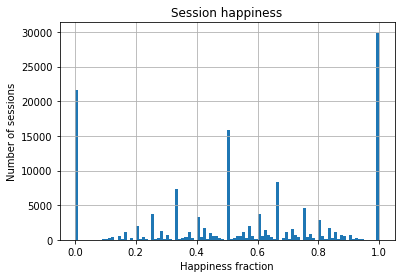

In [ ]:
# Inspect sessions' happiness
grouped.response.hist(bins=100)
plt.title('Session happiness')
plt.xlabel('Happiness fraction')
plt.ylabel('Number of sessions')
plt.show()

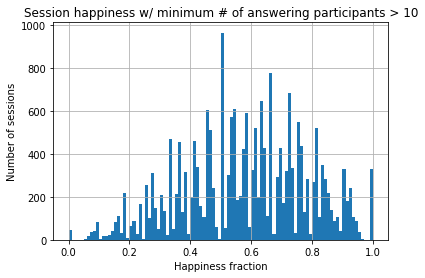

In [ ]:
grouped[grouped.n_participants > 10].response.hist(bins=100)
plt.title('Session happiness w/ minimum # of answering participants > 10')
plt.xlabel('Happiness fraction')
plt.ylabel('Number of sessions')
plt.show()

It seems like a majority of sessions have either 0 or 1 happiness fraction. This could be due to the low number of participants for some sessions, making it easy for sessions to achieve these scores. We might have to consider requiring a minimum number of participant answers to get an unbiased prediction.

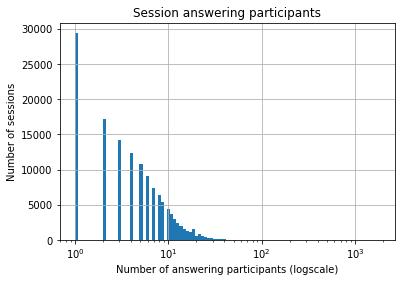

In [ ]:
grouped.n_participants.hist(bins=np.logspace(0, 3.26, 100))
plt.xscale('log')
plt.title('Session answering participants')
plt.xlabel('Number of answering participants (logscale)')
plt.ylabel('Number of sessions')
plt.show()

In [ ]:
print(f'Fraction of sessions with >= 2 answering participants: {len(grouped[grouped.n_participants >= 2])/len(grouped):.4f}')
print(f'Fraction of sessions with >= 5 answering participants: {len(grouped[grouped.n_participants >= 5])/len(grouped):.4f}')
print(f'Fraction of sessions with >= 10 answering participants: {len(grouped[grouped.n_participants >= 10])/len(grouped):.4f}')

Fraction of sessions with >= 2 answering participants: 0.7859
Fraction of sessions with >= 5 answering participants: 0.4674
Fraction of sessions with >= 10 answering participants: 0.1835


Indeed a large fraction of sessions have only one answering participant with a small majority which have >= 10 (less than 20%).

For now, we will keep all sessions; however it might be a good idea to only consider sessions that have at least a minimum number of answering participants.

## Predictions

In [6]:
# Perform train-test split
score = grouped.pop('response')
X_training, X_test, y_training, y_test = train_test_split(grouped, score, test_size=0.1, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.2, random_state=123)

#### Baseline
Simply output average

In [7]:
pred = [np.mean(y_training)] * len(y_test)
print('Baseline performance: ')
print(f'\tMSE: {mean_squared_error(y_test, pred):.4f}')
print(f'\tMAE: {mean_absolute_error(y_test, pred):.4f}')

Baseline performance: 
	MSE: 0.1146
	MAE: 0.2846


#### Neural network predictions
We will first try performing predictions with a simple fully connected neural network

In [ ]:
model = sesh.simple_NN(X_train.shape[1])
sesh.fit_model(model, X_train, y_train, X_val, y_val)
_, _ = sesh.eval_nn_model(model, X_test, y_test)

Epoch 1/20
3090/3090 [==============================] - 9s 3ms/step - loss: 0.1112 - mean_absolute_error: 0.2704 - val_loss: 0.1024 - val_mean_absolute_error: 0.2626
Epoch 2/20
3090/3090 [==============================] - 8s 3ms/step - loss: 0.1023 - mean_absolute_error: 0.2586 - val_loss: 0.1049 - val_mean_absolute_error: 0.2594
Epoch 3/20
3090/3090 [==============================] - 8s 3ms/step - loss: 0.1012 - mean_absolute_error: 0.2574 - val_loss: 0.0984 - val_mean_absolute_error: 0.2535
Epoch 4/20
3090/3090 [==============================] - 8s 2ms/step - loss: 0.1005 - mean_absolute_error: 0.2564 - val_loss: 0.0988 - val_mean_absolute_error: 0.2544
Epoch 5/20
3090/3090 [==============================] - 8s 2ms/step - loss: 0.1003 - mean_absolute_error: 0.2562 - val_loss: 0.0982 - val_mean_absolute_error: 0.2546
Epoch 6/20
3090/3090 [==============================] - 8s 2ms/step - loss: 0.0996 - mean_absolute_error: 0.2555 - val_loss: 0.0992 - val_mean_absolute_error: 0.2548
Epoc

In [ ]:
model = sesh.deep_NN(X_train.shape[1])
sesh.fit_model(model, X_train, y_train, X_val, y_val)
_, _ = sesh.eval_nn_model(model, X_test, y_test)

Epoch 1/20
3090/3090 [==============================] - 11s 3ms/step - loss: 0.1048 - mean_absolute_error: 0.2652 - val_loss: 0.0989 - val_mean_absolute_error: 0.2569
Epoch 2/20
3090/3090 [==============================] - 10s 3ms/step - loss: 0.1005 - mean_absolute_error: 0.2581 - val_loss: 0.0990 - val_mean_absolute_error: 0.2580
Epoch 3/20
3090/3090 [==============================] - 12s 4ms/step - loss: 0.0999 - mean_absolute_error: 0.2568 - val_loss: 0.1022 - val_mean_absolute_error: 0.2584
Epoch 4/20
3090/3090 [==============================] - 10s 3ms/step - loss: 0.0996 - mean_absolute_error: 0.2563 - val_loss: 0.0982 - val_mean_absolute_error: 0.2524
Epoch 5/20
3090/3090 [==============================] - 18s 6ms/step - loss: 0.0993 - mean_absolute_error: 0.2556 - val_loss: 0.0973 - val_mean_absolute_error: 0.2528
Epoch 6/20
3090/3090 [==============================] - 12s 4ms/step - loss: 0.0990 - mean_absolute_error: 0.2551 - val_loss: 0.0983 - val_mean_absolute_error: 0.254

Going deeper does not necessarily largely improve performance. Let's try known regression models on this task as well.
#### Regression models

In [ ]:
gbr = GradientBoostingRegressor()
lr = LinearRegression()

_, _ = sesh.eval_reg_mod(gbr, X_training, y_training, X_test, y_test)
_, _ = sesh.eval_reg_mod(lr, X_training, y_training, X_test, y_test)

Model: GradientBoostingRegressor()
	MSE: 0.0964
	MAE: 0.2505
Model: LinearRegression()
	MSE: 0.0989
	MAE: 0.2540


Gradient Boosting Regressor seems to be slightly better than linear regression and both achieve similar results to the NN architectures. Let's now get rid of sessions with low amount of participants as there are not enough answers to consider the outcome label reliable.

In [8]:
grouped = pd.concat([grouped, score], axis=1)

In [ ]:
X_sub = grouped[grouped.n_participants > 10]
y_sub = X_sub.pop('response')

X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.1, random_state=42)

gbr = GradientBoostingRegressor()
_, _ = sesh.eval_reg_mod(gbr, X_train, y_train, X_test, y_test)

Model: GradientBoostingRegressor()
	MSE: 0.0274
	MAE: 0.1318


Seems like this improves results a lot (as hypothesized)! Let us try to visualize this improvement:

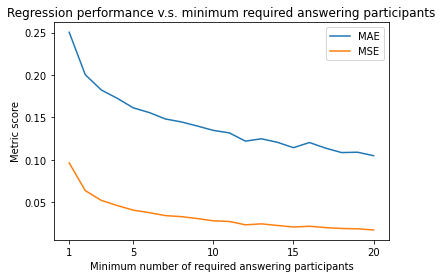

In [ ]:
sesh.low_participants_removed(grouped)

Let's compare MAE between the regression model and deep learning model:

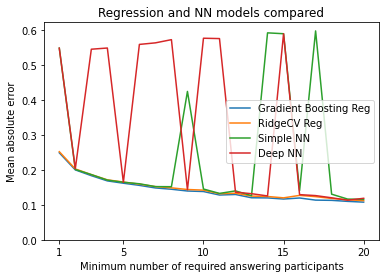

In [ ]:
sesh.compare_reg_deep(grouped)

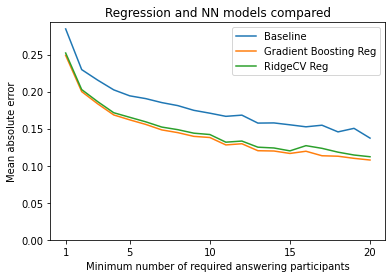

In [13]:
sesh.compare_reg_deep(grouped, include_nn=False, include_baseline=True)

Performance is much more satisfactory as we have seemingly removed answer variance. Let's try to train a Random Forest regressor and look at feature importances for the case when we require at least 10-20 participants:

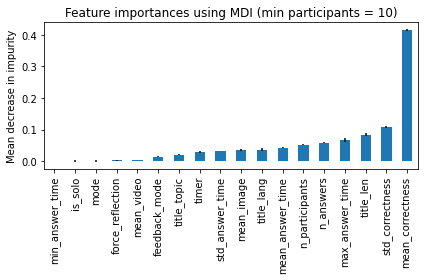

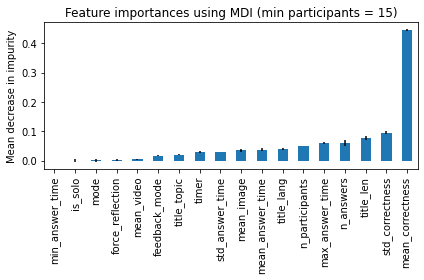

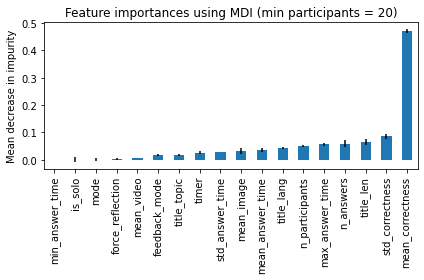

In [ ]:
sesh.rf_reg_importance(grouped, 10)
sesh.rf_reg_importance(grouped, 15)
sesh.rf_reg_importance(grouped, 20)

MAE: 0.14201997212674397


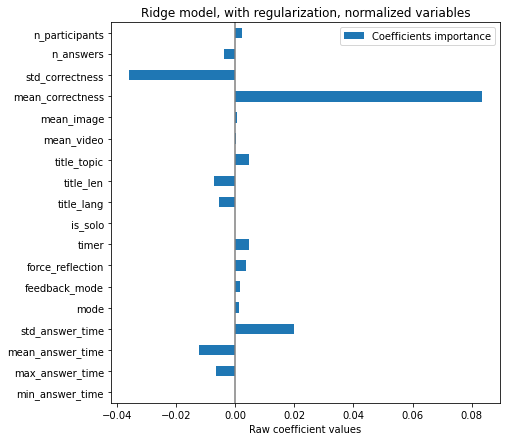

MAE: 0.11176963614266713


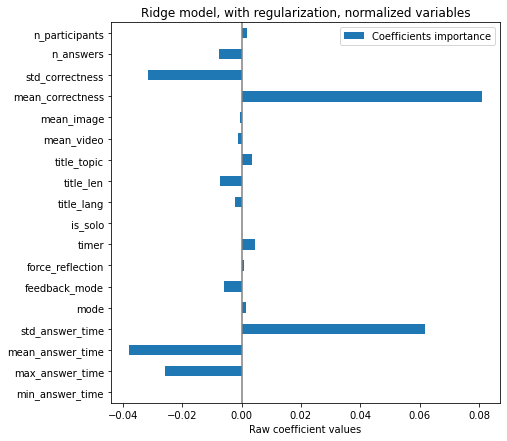

In [ ]:
sesh.ridge_reg_importance(grouped, 10)
sesh.ridge_reg_importance(grouped, 20)

Now, with these results, what would be interesting, is if we decide to predict if a session passes a "happiness quota" (for example at least 60% happiness) as hypothetically required by a school.
#### Moving to binary prediction

In [14]:
# Change outcome label to binary (cutoff at 60%)
grouped['response'] = grouped.response.map(lambda h: 1.0 if h >= 0.6 else 0.0)

# Perform train-val-test split
X = grouped[grouped.n_participants >= 1]
y = X.pop('response')
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.2, random_state=123)

#### Baseline
Most frequent class predictor

In [19]:
most_freq = y_training.value_counts().index[0]
y_pred = [most_freq] * len(y_test)
print('Baseline:')
print(f'Balanced accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}')

Baseline:
Balanced accuracy: 0.5000


#### Simple NN and classifiers

In [ ]:
simple = sesh.simple_NN(X_train.shape[1], out_act='sigmoid', loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=[tf.keras.metrics.BinaryAccuracy()])
sesh.fit_model(simple, X_train, y_train, X_val, y_val)
y_pred = simple.predict(X_test) >= 0.5
print(f'Accuracy: {accuracy_score(y_pred, y_test):.4f}')
print(f'Balanced accuracy: {balanced_accuracy_score(y_pred, y_test):.4f}')
print(f'ROC AUC: {roc_auc_score(y_pred, y_test):.4f}')


Epoch 1/20
3090/3090 [==============================] - 9s 3ms/step - loss: 0.6499 - binary_accuracy: 0.6237 - val_loss: 0.6220 - val_binary_accuracy: 0.6620
Epoch 2/20
3090/3090 [==============================] - 10s 3ms/step - loss: 0.6250 - binary_accuracy: 0.6573 - val_loss: 0.6174 - val_binary_accuracy: 0.6657
Epoch 3/20
3090/3090 [==============================] - 15s 5ms/step - loss: 0.6198 - binary_accuracy: 0.6594 - val_loss: 0.6124 - val_binary_accuracy: 0.6679
Epoch 4/20
3090/3090 [==============================] - 8s 3ms/step - loss: 0.6167 - binary_accuracy: 0.6633 - val_loss: 0.6123 - val_binary_accuracy: 0.6671
Epoch 5/20
3090/3090 [==============================] - 8s 3ms/step - loss: 0.6146 - binary_accuracy: 0.6645 - val_loss: 0.6081 - val_binary_accuracy: 0.6706
Epoch 6/20
3090/3090 [==============================] - 9s 3ms/step - loss: 0.6135 - binary_accuracy: 0.6659 - val_loss: 0.6173 - val_binary_accuracy: 0.6606
Epoch 7/20
3090/3090 [============================

Alright! Let's tune the minimum number of participant answers now:

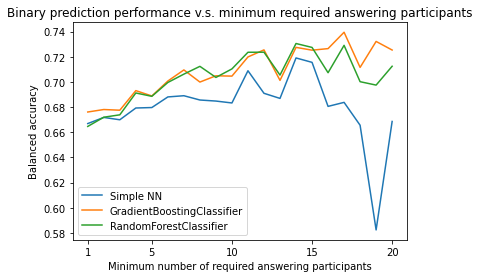

In [ ]:
sesh.binary_lower_participants(grouped)

It seems like the simple Neural Network seems to falter in comparison to the classifiers, especially as datapoints decrease. However, given that sessions are modeled by an aggregation of participant interactions aggregations (aggregation of aggregation) these results are quite promising! Given better chosen input features to better represent a session as a whole by possibly including more information on its questions or deriving added participant features, there is potential to achieve better results.